<a href="https://colab.research.google.com/github/danakhang/freethinker/blob/main/text2image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set up

In [ ]:
import jax
import jax.numpy as jnp

In [ ]:
jax.local_device_count()

1

In [ ]:
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [ ]:
!pip install -q dalle-mini

     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 4.9 MB 60.3 MB/s 
     |████████████████████████████████| 180 kB 72.3 MB/s 
     |████████████████████████████████| 1.8 MB 50.4 MB/s 
     |████████████████████████████████| 236 kB 74.4 MB/s 
     |████████████████████████████████| 216 kB 76.0 MB/s 
     |████████████████████████████████| 217 kB 64.5 MB/s 
     |████████████████████████████████| 145 kB 60.1 MB/s 
     |████████████████████████████████| 51 kB 7.9 MB/s 
     |████████████████████████████████| 85 kB 4.6 MB/s 
     |████████████████████████████████| 6.6 MB 61.6 MB/s 
     |████████████████████████████████| 163 kB 76.9 MB/s 
     |████████████████████████████████| 181 kB 73.1 MB/s 
     |████████████████████████████████| 162 kB 68.6 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 158 kB 73.1 MB/s 
     |████████████████████████████████| 157 kB 73.8 MB/s 
     |████████████████

In [ ]:
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

In [ ]:
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

In [ ]:
from huggingface_hub import hf_hub_url, cached_download, hf_hub_download

In [ ]:
dalle_mini_files_list = ['config.json', 'tokenizer.json', 
             'tokenizer_config.json', 'merges.txt', 'vocab.json', 
             'special_tokens_map.json', 'enwiki-words-frequency.txt', 
             'flax_model.msgpack']

In [ ]:
import shutil

In [ ]:
for each_file in dalle_mini_files_list:
  downloaded_file = hf_hub_download("dalle-mini/dalle-mini", filename=each_file)
  target_path = '/content/dalle-mini/' + each_file
  shutil.copy(downloaded_file, target_path)

Downloading:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.12M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/497 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.75G [00:00<?, ?B/s]

In [ ]:
!ls -lah /content/dalle-mini

total 1.7G
drwxr-xr-x 4 root root 4.0K Sep 29 08:05 .
drwxr-xr-x 1 root root 4.0K Sep 29 07:57 ..
-rw------- 1 root root 1.3K Sep 29 08:02 config.json
-rw------- 1 root root  33M Sep 29 08:02 enwiki-words-frequency.txt
-rw------- 1 root root 1.7G Sep 29 08:06 flax_model.msgpack
drwxr-xr-x 2 root root 4.0K Sep 29 07:58 .ipynb_checkpoints
-rw------- 1 root root 450K Sep 29 08:02 merges.txt
-rw------- 1 root root  239 Sep 29 08:02 special_tokens_map.json
-rw------- 1 root root  497 Sep 29 08:02 tokenizer_config.json
-rw------- 1 root root 2.1M Sep 29 08:02 tokenizer.json
-rw------- 1 root root 783K Sep 29 08:02 vocab.json
drwxr-xr-x 2 root root 4.0K Sep 29 07:58 vqgan


In [ ]:
vqgan_files_list = ['config.json',  'flax_model.msgpack']

In [ ]:
for each_file in vqgan_files_list:
  downloaded_file = hf_hub_download("dalle-mini/vqgan_imagenet_f16_16384", filename=each_file)
  target_path = '/content/dalle-mini/vqgan/' + each_file
  shutil.copy(downloaded_file, target_path)

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/304M [00:00<?, ?B/s]

In [ ]:
!ls -lah /content/dalle-mini/vqgan

total 291M
drwxr-xr-x 2 root root 4.0K Sep 29 08:07 .
drwxr-xr-x 4 root root 4.0K Sep 29 08:05 ..
-rw------- 1 root root  434 Sep 29 08:07 config.json
-rw------- 1 root root 291M Sep 29 08:07 flax_model.msgpack


In [ ]:
DALLE_MODEL_LOCATION = '/content/dalle-mini'
DALLE_COMMIT_ID = None
model, params = DalleBart.from_pretrained(    
    DALLE_MODEL_LOCATION, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False,
)

In [ ]:
model.config

DalleBartConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "architectures": [
    "eBart"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 16385,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 2730,
  "decoder_layers": 12,
  "decoder_start_token_id": 16384,
  "do_sample": true,
  "dropout": 0.0,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 2730,
  "encoder_layers": 12,
  "encoder_vocab_size": 50264,
  "eos_token_id": 16385,
  "force_ln_scale": false,
  "gradient_checkpointing": true,
  "image_length": 256,
  "image_vocab_size": 16384,
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "ln_positions": "normformer",
  "ln_type": "layernorm",
  "max_length": 257,
  "max_text_length": 64,
  "min_length": 257,
  "model_type": "dallebart",
  "normalize_text": true,
  "pad_token_id": 16385,
  "scale_embedding": false,
  "sinkhorn_iters": 1,
  "tau_init": 0.05,
  "tie_word_embeddings": false,
  "transformers_version": "4.22.2",
  "us

In [ ]:
VQGAN_LOCAL_REPO = '/content/dalle-mini/vqgan'
VQGAN_LCOAL_COMMIT_ID = None
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_LOCAL_REPO, revision=VQGAN_LCOAL_COMMIT_ID, _do_init=False
)

In [ ]:
DALLE_MODEL_LOCATION = '/content/dalle-mini'
DALLE_COMMIT_ID = None
processor = DalleBartProcessor.from_pretrained(
    DALLE_MODEL_LOCATION, 
    revision=DALLE_COMMIT_ID)

In [ ]:
processor

In [ ]:
# Works for all available devices to replicate the module
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

#Model Inference


In [ ]:
from functools import partial

In [ ]:
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
  return model.generate(
      **tokenized_prompt,
      prng_key=key,
      params=params,
      top_k=top_k,
      top_p=top_p,
      temperature=temperature,
      condition_scale=condition_scale,
  )

#Decode Images

In [ ]:
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

#Setting up the Text input prompt

In [ ]:
prompts = ['vincent van gogh paintings mixed with car paintings']

prompts = ['a man playing piano paintings']

In [ ]:
tokenized_prompts = processor(prompts)

In [ ]:
tokenized_prompt = replicate(tokenized_prompts)

#Defining model parameters

##random key

In [ ]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

In [ ]:
# number of predictions per prompt
n_predictions = 2

# We can customize generation parameters (see https://huggingface.co/blog/how-to-generate)
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

In [ ]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange

In [ ]:
print(f"Prompts: {prompts}\n")

Prompts: ['pianist playing piano paintings']



  0%|          | 0/2 [00:00<?, ?it/s]

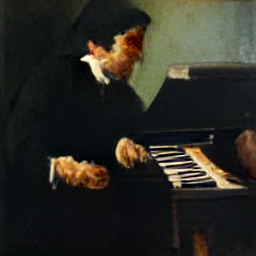

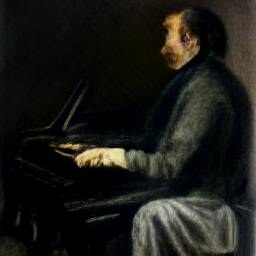

In [ ]:
images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
    # get a new key
    key, subkey = jax.random.split(key)
    # generate images
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
    # decode images
    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for decoded_img in decoded_images:
        img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
        images.append(img)
        display(img)
        print()